# Human vs AI Text Classification

## Data from Kaggle

- [Kaggle Competition](https://www.kaggle.com/competitions/human-vs-ai-text-classification-feb2024/data)
- [Kaggle Dataset](https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text/data)

The data is of the form:

| text | generated |
|------|--------|
| text | 0 |
| text | 1 |
---

where `generated` is a 0 for human or 1 for AI.

The goal of this notebook is to classify whether a given text is written by a human or AI. I will be using a combination of traditional NLP techniques and more modern approaches using transformers and transfer learning.

## Imports

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import re
import string

# NLTK
import nltk
from nltk.corpus import words, stopwords
from nltk.tokenize import word_tokenize

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Scikit-learn models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


import matplotlib.pyplot as plt
# NLTK Data
try:
    nltk.data.find('corpora/words')
except LookupError:
    nltk.download('words')
    
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

## Helper Functions

In [2]:
# Create a set of English words
english_words = set(words.words())

# Function to count misspelled words
def count_misspelled_words(text):
    word_list = nltk.word_tokenize(text.lower())
    misspelled = sum(1 for word in word_list if word.isalpha() and word not in english_words)
    return misspelled


def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    # stop_words = set(stopwords.words('english'))
    # tokens = [word for word in tokens if word not in stop_words]
    
    # Join the tokens back into a string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

## Code

In [3]:
# Load the data
df1 = pd.read_csv('data/train.csv')
df2 = pd.read_csv('data/AI_Human.csv')
test_df = pd.read_csv('data/test.csv')

df = pd.concat([df1, df2])

# Delete the original dataframes to save memory
del df1, df2

# Drop duplicates
df = df.drop_duplicates()
# train.csv seems to be already contained in Ai_Human.csv
# Save the dataframe to a new csv file
# labels are imbalanced 305797 human and 1181438 AI
df.to_csv('data/no_duplicates.csv', index=False)

# Split the data into training and testing sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'], df['generated'], test_size=0.2, random_state=42, stratify=df['generated'])

# Clean the text data
train_texts_cleaned = train_texts.apply(clean_text)
val_texts_cleaned = val_texts.apply(clean_text)

In [4]:
# Combine TF-IDF features with extra features
tfidf = TfidfVectorizer(max_features=1000)
train_features = tfidf.fit_transform(train_texts)
val_features= tfidf.transform(val_texts)

print("Shape of training features:", train_features.shape)
print("Shape of validation features:", val_features.shape)

Shape of training features: (389788, 1000)
Shape of validation features: (97447, 1000)


In [5]:
# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(zip(np.unique(train_labels), class_weights))
print("Class weights:", class_weight_dict)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'Weighted Logistic Regression': LogisticRegression(class_weight=class_weight_dict),
}

# Evaluate each model using cross-validation
for name, model in models.items():
    scores = cross_val_score(model, train_features, train_labels, cv=5)
    print(f"{name}: Mean accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")


Class weights: {np.float64(0.0): np.float64(0.796662824254613), np.float64(1.0): np.float64(1.3427075439200826)}
Logistic Regression: Mean accuracy: 0.9877 (+/- 0.0006)
Naive Bayes: Mean accuracy: 0.9178 (+/- 0.0017)
Weighted Logistic Regression: Mean accuracy: 0.9873 (+/- 0.0005)


## Save and evaluate models

In [6]:
import joblib
import os

# Create a directory to store the models if it doesn't exist
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')
    
# Train and save each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(train_features, train_labels)
    
    # Save the model
    joblib.dump(model, f'saved_models/{name.replace(" ", "_").lower()}.joblib')
    print(f"{name} saved.")

    # Evaluate the model
    val_pred = model.predict(val_features)
    accuracy = accuracy_score(val_labels, val_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(val_labels, val_pred))
    print("\n")

Training Logistic Regression...
Logistic Regression saved.
Logistic Regression Accuracy: 0.9886
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     61159
         1.0       0.99      0.98      0.98     36288

    accuracy                           0.99     97447
   macro avg       0.99      0.99      0.99     97447
weighted avg       0.99      0.99      0.99     97447



Training Naive Bayes...
Naive Bayes saved.
Naive Bayes Accuracy: 0.9176
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94     61159
         1.0       0.96      0.81      0.88     36288

    accuracy                           0.92     97447
   macro avg       0.93      0.90      0.91     97447
weighted avg       0.92      0.92      0.92     97447



Training Weighted Logistic Regression...
Weighted Logistic Regression saved.
Weighted Logistic Regression Accuracy: 0.9880
              precision    recall  f1-score   suppo

### Load the saved models and plot the feature importance

In [7]:
# Load the saved models
unweighted_lr = joblib.load('saved_models/logistic_regression.joblib')
unweighted_nb = joblib.load('saved_models/naive_bayes.joblib')
weighted_lr = joblib.load('saved_models/weighted_logistic_regression.joblib')

Unweighted Logistic Regression Feature Importance:


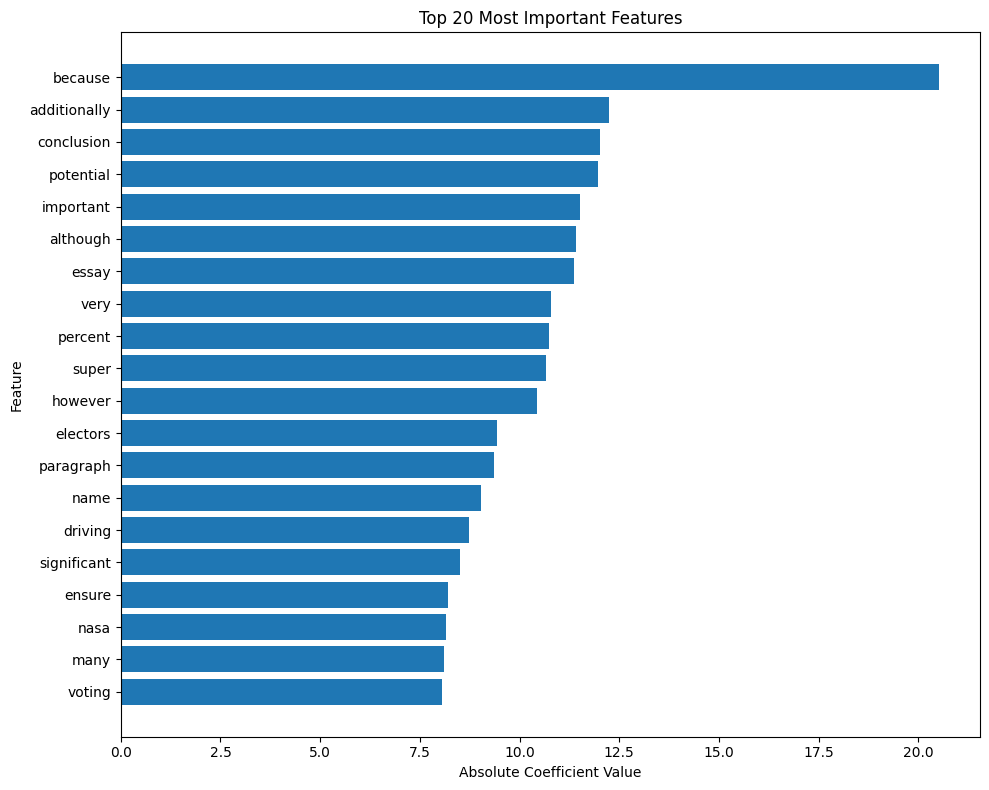


Weighted Logistic Regression Feature Importance:


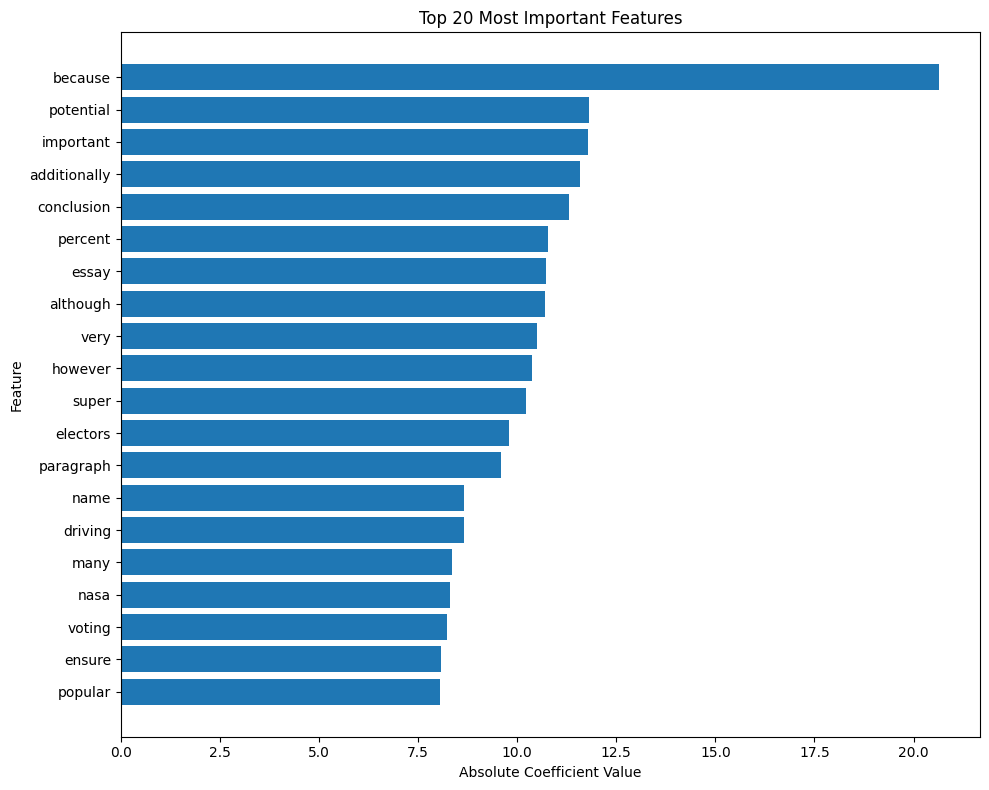


Unweighted Logistic Regression:
Top 10 most important features:
because: -20.5205
additionally: 12.2340
conclusion: 12.0181
potential: 11.9622
important: 11.5210
although: -11.4083
essay: 11.3631
very: -10.7960
percent: -10.7420
super: 10.6694

Weighted Logistic Regression:
Top 10 most important features:
because: -20.6439
potential: 11.8056
important: 11.7908
additionally: 11.5938
conclusion: 11.3000
percent: -10.7688
essay: 10.7399
although: -10.7003
very: -10.5114
however: 10.3839


In [8]:
def plot_feature_importance(model, feature_names, top_n=20):
    # Get feature coefficients
    coefficients = model.coef_[0]
    
    # Create a dataframe of features and their coefficients
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': abs(coefficients)})
    
    # Sort by absolute importance and get top n
    feature_importance = feature_importance.sort_values('importance', ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title(f'Top {top_n} Most Important Features')
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
    plt.tight_layout()
    plt.show()
    
# Get feature names
tfidf_feature_names = tfidf.get_feature_names_out()


# Plot feature importance for unweighted Logistic Regression
print("Unweighted Logistic Regression Feature Importance:")
plot_feature_importance(unweighted_lr, tfidf_feature_names)

# Plot feature importance for weighted Logistic Regression
print("\nWeighted Logistic Regression Feature Importance:")
plot_feature_importance(weighted_lr, tfidf_feature_names)

# Print top 10 most important features and their coefficients
def print_top_features(model, feature_names, top_n=10):
    coefficients = model.coef_[0]
    feature_importance = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
    feature_importance['abs_coefficient'] = abs(feature_importance['coefficient'])
    top_features = feature_importance.sort_values('abs_coefficient', ascending=False).head(top_n)
    
    print(f"Top {top_n} most important features:")
    for _, row in top_features.iterrows():
        print(f"{row['feature']}: {row['coefficient']:.4f}")

print("\nUnweighted Logistic Regression:")
print_top_features(unweighted_lr, tfidf_feature_names)

print("\nWeighted Logistic Regression:")
print_top_features(weighted_lr, tfidf_feature_names)

### Summary of Feature Importances in Logistic Model for Predicting Human vs. AI-Generated Text

1. **Positive vs. Negative Coefficients:**
   - **Positive Coefficients** are associated with features that increase the likelihood of the text being AI-generated. These words or phrases tend to be more formal, structured, and indicative of AI's approach to constructing text.
   - **Negative Coefficients** are linked to features that increase the likelihood of the text being human-written. These words or phrases reflect a more casual, natural style, often involving causal explanations and contrasting ideas, characteristic of human writing.

2. **Magnitude of Coefficients:**
   - The magnitude (absolute value) of the coefficients indicates the significance of each feature in the model's predictions. Features with larger magnitudes have a stronger impact on whether the model classifies text as AI-generated or human-written.

3. **Insights:**
   - **AI-Generated Text** tends to exhibit a formal, structured style with explicit transitions and conclusions. This language is often more formulaic, emphasizing clarity and organization.
   - **Human-Written Text** displays a more casual and varied style, often using causal explanations and contrasting ideas. This reflects human creativity and a flexible approach to writing.